# Group 005 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [2]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [3]:
# import zipfile
# with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [6]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
2693163,1669000,2019-10-04,06:36:06,55.030393,83.015545,9654,1,7,10,-1,59.02,8.0,11
2969637,7000000,2019-12-01,18:22:06,55.018901,82.946261,9654,3,16,16,2,81.00,12.4,1
2856045,7937040,2019-11-08,16:38:31,55.881606,37.683976,3,2,5,25,2,50.00,11.0,1
284506,1155000,2018-10-17,00:17:57,54.935570,82.885260,9654,2,1,17,1,23.00,5.0,1
1291923,2500000,2019-03-03,00:22:45,55.743462,52.395916,2922,3,6,24,1,36.00,10.0,11


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [7]:
MOSCOW_CODE = 81
MAX_NUM_SAMPLES = 100000
SEED = 69

RUBLE_TO_DOLLAR = 0.012

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]
moscow_df['price'] = moscow_df['price'] * RUBLE_TO_DOLLAR

# cap number of elements
moscow_df = moscow_df.sample(MAX_NUM_SAMPLES, random_state=SEED)

In [8]:
moscow_df.isnull().values.any()

False

In [9]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
2167508,91080.00,2019,monolithic,10,23,2,58.0,11.0,new
685092,19800.00,2018,brick,3,5,1,32.0,7.0,preowned
5316080,70200.00,2021,brick,4,5,2,43.0,6.0,preowned
2876983,26280.00,2019,panel,7,10,0,39.1,9.0,preowned
5473187,151915.92,2021,panel,4,15,2,66.0,11.4,new


## Exploration

First, we'll look at the data distributions for the ordinal data.

In [10]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.707663e+04,2019.310120,7.053700,12.752370,1.776320,51.592710,10.362995
std,3.556933e+04,0.880621,5.692804,7.411351,0.862656,21.748209,6.834285
min,1.800000e+01,2018.000000,1.000000,1.000000,0.000000,2.400000,0.120000
25%,3.600000e+04,2019.000000,3.000000,5.000000,1.000000,38.000000,7.000000
50%,5.160000e+04,2019.000000,5.000000,12.000000,2.000000,46.000000,9.700000
75%,7.140000e+04,2020.000000,10.000000,17.000000,2.000000,61.900000,12.000000
max,3.572896e+06,2021.000000,36.000000,38.000000,9.000000,997.000000,1131.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

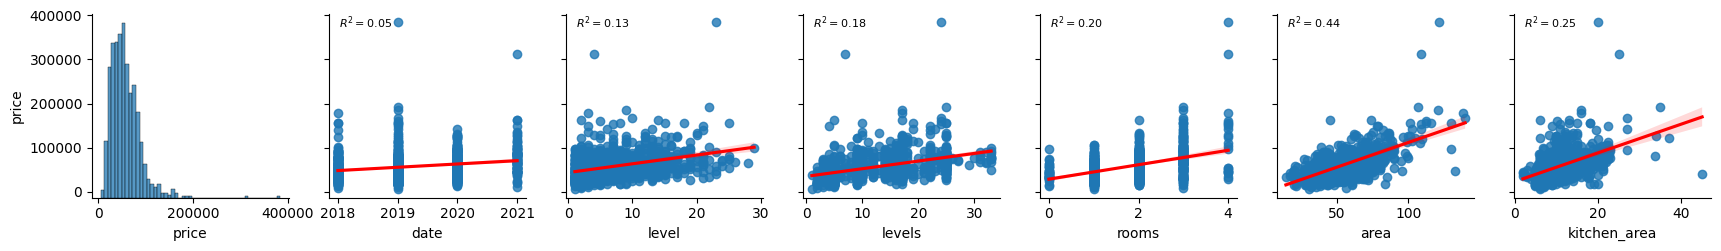

In [11]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000, random_state=21), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like they might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

<Axes: >

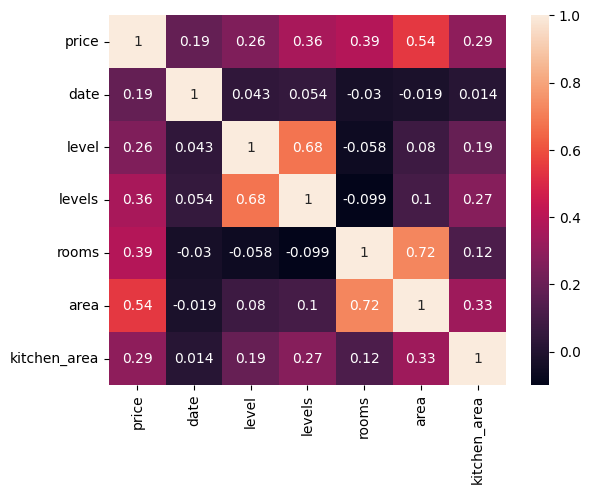

In [12]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [13]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

70000 train samples; 30000 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [14]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
3927582,2020,13,17,2,63.0,12.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
615052,2018,6,25,3,78.7,12.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4807619,2020,2,17,3,57.8,17.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2180761,2019,17,24,3,77.8,13.9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4359914,2020,13,16,1,39.2,10.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [15]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
2433194,-0.350955,-0.540510,-1.052022,0.257887,-0.302934,-0.581066,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4102756,0.784297,-1.068113,0.432760,0.257887,-0.321183,-0.581066,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2345847,-0.350955,1.218169,1.242640,-2.057966,-1.183427,-0.673662,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3644103,0.784297,-1.068113,-0.512101,-0.900040,-0.845829,-0.382647,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3610627,0.784297,-0.892245,-1.456962,0.257887,-0.211691,-0.051948,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
gkeokde

NameError: name 'gkeokde' is not defined

### Rapids CuML Setup

In [ ]:
import cudf
import cupy as cp

def to_cudf(pd_df):
    data = dict()

    for col in pd_df.columns:
        data[col] = pd_df[col].to_numpy(dtype=np.float32)

    return cudf.DataFrame(data)

def to_cupy(pd_df):
    return cp.from_dlpack(pd_df.to_dlpack())

In [ ]:
X_train_cudf = to_cudf(X_train)
X_test_cudf = to_cudf(X_test)

X_train_cupy = to_cupy(X_train_cudf)
X_test_cupy = to_cupy(X_test_cudf)

In [ ]:
X_train_scaled_cudf = to_cudf(X_train_scaled)
X_test_scaled_cudf = to_cudf(X_test_scaled)

X_train_scaled_cupy = to_cupy(X_train_scaled_cudf)
X_test_scaled_cupy = to_cupy(X_test_scaled_cudf)

In [ ]:
y_train_cudf = cudf.Series(y_train.to_numpy())
y_test_cudf = cudf.Series(y_test.to_numpy())

y_train_cupy = to_cupy(y_train_cudf)
y_test_cupy = to_cupy(y_test_cudf)

In [ ]:
from sklearn.metrics import mean_absolute_error

def custom_grid_search(model, hparams, default_kwargs, X_train_cupy, y_train_cupy,
                       folds=3, verbose=0):
    import itertools
    
    # note that KFold in SciKit by default does not use shuffling, so we will not do so here
    X_splits = cp.array_split(X_train_cupy, folds)
    y_splits = cp.array_split(y_train_cupy, folds)
    cv_scores = dict()

    cuml_model = model(**default_kwargs)
    for hparam_comb in itertools.product(*hparams.values()):
        kwargs = dict(zip(hparams.keys(), hparam_comb))
        
        holdouts = []
        
        if verbose >= 1:
            print(f'Training CV with {folds} folds on hparams {kwargs}')

        cuml_model.set_params(**kwargs, **default_kwargs)
        # rf_cuml = cuRF(n_estimators=n_est, accuracy_metric='mean_ae', verbose=False, random_state=SEED, n_streams=1)
        
        for i in range(folds):
            
            train_sets = [X_splits[j] for j in range(len(X_splits)) if j != i]
            label_sets = [y_splits[j] for j in range(len(y_splits)) if j != i]
                
            train_arr = cp.vstack(train_sets)
            labels_arr = cp.hstack(label_sets)
            cuml_model.fit(train_arr, labels_arr)
            
            preds = cuml_model.predict(X_splits[i])   
            score = mean_absolute_error(cp.asnumpy(preds), cp.asnumpy(y_splits[i]))     
            holdouts.append(score)
            
            if verbose >= 2:
                print(f'\tholdout {i}: {score}')
            
            del train_arr, labels_arr, train_sets, label_sets
                    
        cv_score = np.mean(holdouts)
        cv_scores[str(kwargs)] = cv_score
        
        if verbose >= 1:
            print('CV Score:', cv_score)
            
    del X_splits, y_splits
    
    return cv_scores

In [ ]:
from cuml.common.device_selection import using_device_type, set_global_device_type
import pickle
set_global_device_type('GPU')

In [ ]:
gkeokde

NameError: name 'gkeokde' is not defined

### Linear Regression

Unfortunately CuML does not natively support MAE Loss for linear regression. However, we can still perfrom mini-batch SGD linear regression and measure MAE loss after-the-fact. We expect this will increase the end MAE loss, and thus negatively affect the model's performance.

**NOTE**: Oftentimes many one-hotted features can negatively impact performance for linear regression. To address this,
1. we will train on both the ordinal+categorical data, as well as just the ordinal data
2. we will use other models which aren't affected by many categorical features (e.g. random forests)

In [ ]:
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor

In [ ]:
learning_rates = [1e-3, 5e-4, 1e-4]
penatlies = ['none', 'l1', 'l2']
epochs = [5, 10, 20]
variable_lr = ['constant', 'adaptive']

hparam_grid = dict(
    learning_rate=variable_lr,
    eta0=learning_rates,
    penalty=penatlies,
    epochs=epochs,
)

def_kwargs = dict(
    loss='squared_loss',
    tol=0.0,
    fit_intercept=True,
    batch_size=16,
    verbose=False,
)

In [ ]:
cv_scores_sgd = custom_grid_search(cumlMBSGDRegressor, hparam_grid, def_kwargs, X_train_scaled_cupy, y_train_cupy, folds=3, verbose=1)

Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'none', 'epochs': 5}
CV Score: 14506.717329699022
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'none', 'epochs': 10}
CV Score: 13695.523520984018
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'none', 'epochs': 20}
CV Score: 13708.488582632881
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l1', 'epochs': 5}
CV Score: 14506.716805976634
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l1', 'epochs': 10}
CV Score: 13695.523508205843
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l1', 'epochs': 20}
CV Score: 13708.488665499133
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l2', 'epochs': 5}
CV Score: 14506.47576062543
Training CV

In [ ]:
opt_sgd_params = min(cv_scores_sgd, key=cv_scores_sgd.get)

print(opt_sgd_params)

{'learning_rate': 'constant', 'eta0': 0.0005, 'penalty': 'l2', 'epochs': 10}


In [ ]:
opt_sgd_params = {'learning_rate': 'constant', 'eta0': 0.0005, 'penalty': 'l2', 'epochs': 10}
def_kwargs['verbose'] = 2
opt_sgd_model = cumlMBSGDRegressor(**opt_sgd_params, **def_kwargs)

opt_sgd_model.fit(X_train_scaled_cupy, y_train_cupy)

MBSGDRegressor()

In [ ]:
opt_sgd_preds = opt_sgd_model.predict(X_test_scaled_cupy)   
opt_sgd_score = mean_absolute_error(cp.asnumpy(opt_sgd_preds), cp.asnumpy(y_test_cupy))     
print('MBSGDRegressor MAE:', opt_sgd_score)

MBSGDRegressor MAE: 13698.269152746356


### Random Forests for Regression

In [ ]:
from cuml.ensemble import RandomForestRegressor as cuRF

In [ ]:
n_estimators = [100, 300, 500, 600]
max_depth = [10, 40, 100]
min_samples_split = [2, 5, 10]

hparam_grid = dict(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
)

def_kwargs = dict(
    accuracy_metric='mean_ae',
    verbose=False,
    random_state=SEED,
    n_streams=1,
)

In [ ]:
cv_scores_RF = custom_grid_search(cuRF, hparam_grid, def_kwargs, X_train_cupy, y_train_cupy, folds=3, verbose=1)

Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
CV Score: 12262.603246456178
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}
CV Score: 12258.12945560379
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10}
CV Score: 12250.63613764298
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 2}
CV Score: 12050.330507251123
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 5}
CV Score: 11982.79636236684
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 10}
CV Score: 11896.202565839785
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 2}
CV Score: 12050.330782143443
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 5}
CV S

In [ ]:
opt_rf_params = min(cv_scores_RF, key=cv_scores_RF.get)

print(opt_rf_params)

{'n_estimators': 600, 'max_depth': 40, 'min_samples_split': 10}


In [ ]:
opt_rf_params = {'n_estimators': 600, 'max_depth': 40, 'min_samples_split': 10}
def_kwargs['verbose'] = 2
opt_rf_model = cuRF(**opt_rf_params, **def_kwargs)

opt_rf_model.fit(X_train_cupy, y_train_cupy)

RandomForestRegressor()

In [ ]:
opt_rf_preds = opt_rf_model.predict(X_test_cupy)   
opt_rf_score = mean_absolute_error(cp.asnumpy(opt_rf_preds), cp.asnumpy(y_test_cupy))     
print('RandomForest MAE:', opt_rf_score)

RandomForest MAE: 11737.414786409116


### KNN Regression

In [ ]:
from cuml.neighbors import KNeighborsRegressor

In [ ]:
n_neighbors = list(np.arange(1, 100))

hparam_grid = dict(
    n_neighbors=n_neighbors,
)

def_kwargs = dict(
    verbose=False,
)

In [ ]:
cv_scores_knn = custom_grid_search(KNeighborsRegressor, hparam_grid, def_kwargs, X_train_scaled_cupy, y_train_cupy, folds=3, verbose=1)

Training CV with 3 folds on hparams {'n_neighbors': 1}
CV Score: 15466.870014626787
Training CV with 3 folds on hparams {'n_neighbors': 2}
CV Score: 14055.782030352873
Training CV with 3 folds on hparams {'n_neighbors': 3}
CV Score: 13502.340671844597
Training CV with 3 folds on hparams {'n_neighbors': 4}
CV Score: 13212.821199914635
Training CV with 3 folds on hparams {'n_neighbors': 5}
CV Score: 12986.295061238236
Training CV with 3 folds on hparams {'n_neighbors': 6}
CV Score: 12854.623304569424
Training CV with 3 folds on hparams {'n_neighbors': 7}
CV Score: 12792.717591420922
Training CV with 3 folds on hparams {'n_neighbors': 8}
CV Score: 12724.20217262097
Training CV with 3 folds on hparams {'n_neighbors': 9}
CV Score: 12674.72208192527
Training CV with 3 folds on hparams {'n_neighbors': 10}
CV Score: 12644.739660445615
Training CV with 3 folds on hparams {'n_neighbors': 11}
CV Score: 12611.566914776544
Training CV with 3 folds on hparams {'n_neighbors': 12}
CV Score: 12582.4469

In [ ]:
opt_knn_params = min(cv_scores_knn, key=cv_scores_knn.get)

print(opt_knn_params)

{'n_neighbors': 29}


In [ ]:
opt_knn_params = {'n_neighbors': 29}
def_kwargs['verbose'] = 2
opt_knn_model = KNeighborsRegressor(**opt_knn_params, **def_kwargs)

opt_knn_model.fit(X_train_scaled_cupy, y_train_cupy)

KNeighborsRegressor()

In [ ]:
opt_knn_preds = opt_knn_model.predict(X_test_cupy)   
opt_knn_score = mean_absolute_error(cp.asnumpy(opt_knn_preds), cp.asnumpy(y_test_cupy))     
print('KNeighborsRegressor MAE:', opt_knn_score)

KNeighborsRegressor MAE: 12425.158850391666


### XGBoost Regression

In [ ]:
from xgboost import XGBRegressor

xg_boost_model = XGBRegressor(
    objective= 'reg:absoluteerror',
    tree_method='gpu_hist',
    nthread=4,
    seed=SEED,
)

params = {
    'learning_rate': [0.1, 0.01, 0.05],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': range(2, 10, 1),
    'n_estimators': [100, 500, 1000, 2000],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

xg_rand_search = RandomizedSearchCV(xg_boost_model, params, n_iter=100,
                                    scoring='neg_mean_absolute_error', cv=3,
                                    random_state=SEED, verbose=1, refit=True,)

In [ ]:
xg_rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=None,
                                          nthread=4, num_parallel_tree=None,
                                          objective='reg:absoluteerror', ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': range(2, 10),
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=69, scoring='neg_mean_absolute_error',
                   verbose=1)

In [ ]:
xg_rand_search.best_params_

{'subsample': 0.8,
 'n_estimators': 2000,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [ ]:
opt_xg_boost_model = XGBRegressor(
    objective= 'reg:absoluteerror',
    tree_method='gpu_hist',
    nthread=4,
    seed=SEED,
    # opt parameters
    subsample=0.8,
    n_estimators=2000,
    max_depth=2,
    learning_rate=0.1,
    gamma=2,
    colsample_bytree=0.6
)

opt_xg_boost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:absoluteerror', ...)

In [ ]:
opt_xg_boost_preds = opt_xg_boost_model.predict(X_test)
opt_xg_boost_score = mean_absolute_error(opt_xg_boost_preds, y_test)
print('XGBoostRegressor MAE:', opt_xg_boost_score)

XGBoostRegressor MAE: 11922.813671071091


### DNN For Regression

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

device

device(type='cuda')

In [ ]:
class RealEstateDataset(Dataset):
    def __init__(self, X_train, y_train, X_test, y_test, train=True, max_cache_size=800000):
        self.df = df
        self.train = train

        self.X = X_train if self.train else X_test
        self.y = y_train if self.train else y_test

        self.cache = dict()
        self.max_cache_size = max_cache_size

    def __getitem__(self, index):

        if index in self.cache.keys():
            return self.cache[index]

        X_sample = torch.tensor(self.X[index]).to(torch.float32).squeeze()
        y_sample = torch.tensor(self.y[index]).to(torch.float32).squeeze()

        if len(self.cache) >= self.max_cache_size:
            self.cache.popitem()

        self.cache[index] = (X_sample, y_sample)

        return self.cache[index]

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = RealEstateDataset(X_train_scaled.to_numpy(), y_train.to_numpy(), X_test_scaled.to_numpy(), y_test.to_numpy(), train=True)
test_dataset = RealEstateDataset(X_train_scaled.to_numpy(), y_train.to_numpy(), X_test_scaled.to_numpy(), y_test.to_numpy(), train=False)

In [ ]:
class RegressionDNN(nn.Module):
    def __init__(self, input_size, fcs=[24, 12, 6, 1], dropout=None):
        super(RegressionDNN, self).__init__()

        self.input_size = input_size
        self.fcs = fcs
        self.dropout = dropout

        self.model = nn.Sequential(
            *self._make_layers()
        )

        self.model.apply(self.init_weights)

    def _make_layers(self):
        layers = [nn.Linear(self.input_size, self.fcs[0])]

        for i in range(len(self.fcs) - 1):
            layers.append(nn.LeakyReLU())
            if self.dropout is not None:
                layers.append(nn.Dropout(self.dropout))
            layers.append(nn.Linear(self.fcs[i], self.fcs[i+1]))

        return layers
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.model(x).squeeze()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5000
DATA_DIMS = train_dataset[0][0].size(0)

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
from tqdm import tqdm
import sys
from pathlib import Path
import os
import wandb

def save(model, optimizer, save_path='model_checkpoint.pt'):

    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }

    torch.save(save_dict, save_path)

def load(model, optimizer, load_path='model_checkpoint.pt'):

    checkpoint = torch.load(load_path, map_location=device)

    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def train(train_dl, test_dl, epochs=EPOCHS, batch_size=BATCH_SIZE, input_size=DATA_DIMS, print_batch_every=None,
          lr=1e-4, dropout=None,
          checkpoint_dir='./checkpoints', pretrained_path=None,
          logging = False, log_init = False, project_name='Russian-Real-Estate-Regression', group_name='DNN', run_name=None,
          model_fcs=None):
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    if logging and log_init:
        wandb.init(project=project_name, group=group_name, name=run_name, config=dict(
            batch_size = batch_size,
            epochs = epochs,
            fcs = str(model_fcs),
            lr = lr,
            dropout=dropout,
            ReLU='leaky',
            opt='Adam'
        ))

    model = RegressionDNN(input_size, fcs=model_fcs, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if pretrained_path is not None:
        model, optimizer = load(model, optimizer, load_path=pretrained_path)

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):

        model.train()

        batch = 0
        train_loss = 0
        for data in iter(train_dl):
            batch += 1

            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()

            pred = model(X)

            loss = F.l1_loss(pred, y * 1e-3, reduction='sum')
            train_loss += loss

            loss.backward()
            optimizer.step()

            if print_batch_every is not None and ((batch-1) % print_batch_every == 0):
                print(f'epoch: {epoch}\tbatch: {batch}/{len(train_dl)}\ttrain_loss: {loss.item()}', file=sys.stderr)

        train_loss /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():

            batch = 0
            test_loss = 0
            for data in iter(test_dl):
                batch += 1

                X, y = data

                X = X.to(device)
                y = y.to(device)

                pred = model(X)

                loss = F.l1_loss(pred, y * 1e-3, reduction='sum')
                test_loss += loss

                if print_batch_every is not None and ((batch-1) % print_batch_every == 0):
                    print(f'epoch: {epoch}\tbatch: {batch}/{len(test_dl)}\ttest_loss: {loss.item()}', file=sys.stderr)

            test_loss /= len(test_dl.dataset)

        save_path = Path(checkpoint_dir) / Path(f'reg_model_{epoch}.pt')
        save(model, optimizer, save_path=str(save_path))

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if logging:
            wandb.log({ 'train/loss': train_loss * 1e3, 'test/loss': test_loss * 1e3 })

    if logging:
        wandb.finish()

    return model, train_losses, test_losses

In [ ]:
for lr in [1e-4, 1e-5, 5e-5]:
    trained_model, train_losses, test_losses = train(train_dl, test_dl, logging=False, log_init=False,
                                project_name='Russian-Real-Estate-Regression', group_name='DNN-Training', run_name=f'adam_leakyrelu_lr={lr}',
                                print_batch_every=None, checkpoint_dir=f'./checkpoints/train_adam_leakyrelu_lr={lr}',
                                model_fcs=[128, 256, 256, 256, 1], lr=lr, dropout=None, epochs=500)

In [ ]:
def eval(test_dl, model_fcs=[128, 256, 256, 256, 1], input_size=DATA_DIMS, dropout=None, pretrained_path=None):
    
    model = RegressionDNN(input_size, fcs=model_fcs, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    model, optimizer = load(model, optimizer, load_path=pretrained_path)
    
    with torch.no_grad():

        all_preds = []
        batch = 0
        test_loss = 0
        for data in iter(test_dl):
            batch += 1

            X, y = data

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            all_preds.append(pred)

            loss = F.l1_loss(pred, y * 1e-3, reduction='sum')
            test_loss += loss

        test_loss /= len(test_dl.dataset)
        
    return test_loss.item() * 1e3, torch.hstack(all_preds) * 1e3

In [ ]:
opt_dnn_loss, opt_dnn_preds = eval(test_dl, pretrained_path='./checkpoints/train_adam_leakyrelu_lr=0.0001/reg_model_100.pt')

print('Regression DNN MAE:', opt_dnn_loss)

Regression DNN MAE: 11860.313415527344


### Performance Analysis of Different Models

Recall the MAE test performance for the optimal hyperparams for each regression algorithm:
- MB SGB Linear Reg: `13698.269152746356`
- Random Forest: `11737.414786409116`
- KNN: `12425.158850391666`
- XGBoost: `11922.813671071091`
- DNN: `11860.313415527344`

Recall that the price data is scaled such that MAE has units of US Dollars.

We now analyze the peformance of each trained model across the price distribution.

In [17]:
opt_sgd_preds = np.loadtxt('./opt_sgb_preds.csv')
opt_rf_preds = np.loadtxt('./opt_rf_preds.csv')
opt_knn_preds = np.loadtxt('./opt_knn_preds.csv')
opt_xg_boost_preds = np.loadtxt('./opt_xg_boost_preds.csv')
opt_dnn_preds = np.loadtxt('./opt_dnn_preds.csv')

In [18]:
pred_df = pd.DataFrame()
pred_df['Price'] = y_test
pred_df['LinReg'] = opt_sgd_preds
pred_df['RF'] = opt_rf_preds
pred_df['KNN'] = opt_knn_preds
pred_df['XGBoost'] = opt_xg_boost_preds
pred_df['DNN'] = opt_dnn_preds * 1e3

In [27]:
def get_scatter(pred_df,
                models=['LinReg', 'RF', 'KNN', 'XGBoost', 'DNN'],
                rows=2, figsize=(20,10),
                price_bounds=(0, 200000), step=10000):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math

    def mae_by_price(price_df, model='RF', price_bounds=price_bounds, step=step):
        lb, ub = price_bounds

        price_df = price_df[price_df['Price'] >= lb]
        price_df = price_df[price_df['Price'] <= ub]

        price_bounds = range(lb, ub+step, step)
        price_by_range = dict()

        for i in range(len(price_bounds) - 1):
            low = price_bounds[i]
            high = price_bounds[i+1]

            curr_df = price_df[price_df['Price'] >= low]
            curr_df = price_df[price_df['Price'] <= high]

            price_by_range[f'{low}-{high}'] = np.mean(curr_df[model] - curr_df['Price'])

        price_by_range_df = pd.DataFrame()
        price_by_range_df['Ground Truth Price Range'] = price_by_range.keys()
        price_by_range_df[f'{model} MAE'] = price_by_range.values()

        return price_by_range_df

    cols = math.ceil(len(models) / rows)

    fig, axes = plt.subplots(
        nrows=rows, ncols=cols, sharex=False, sharey=True, figsize=figsize
    )

    ii, jj = -1, 0
    for i, model_name in enumerate(models):
        if i % cols == 0:
            ii += 1
            jj = 0
        else:
            jj += 1
        
        plot_df = mae_by_price(pred_df, model=model_name)

        sns.barplot(data=plot_df, x=f'{model_name} MAE', y='Ground Truth Price Range', orient='h', ax=axes[ii, jj])
        axes[ii, jj].title.set_text(f'{model_name} MAE by Price')

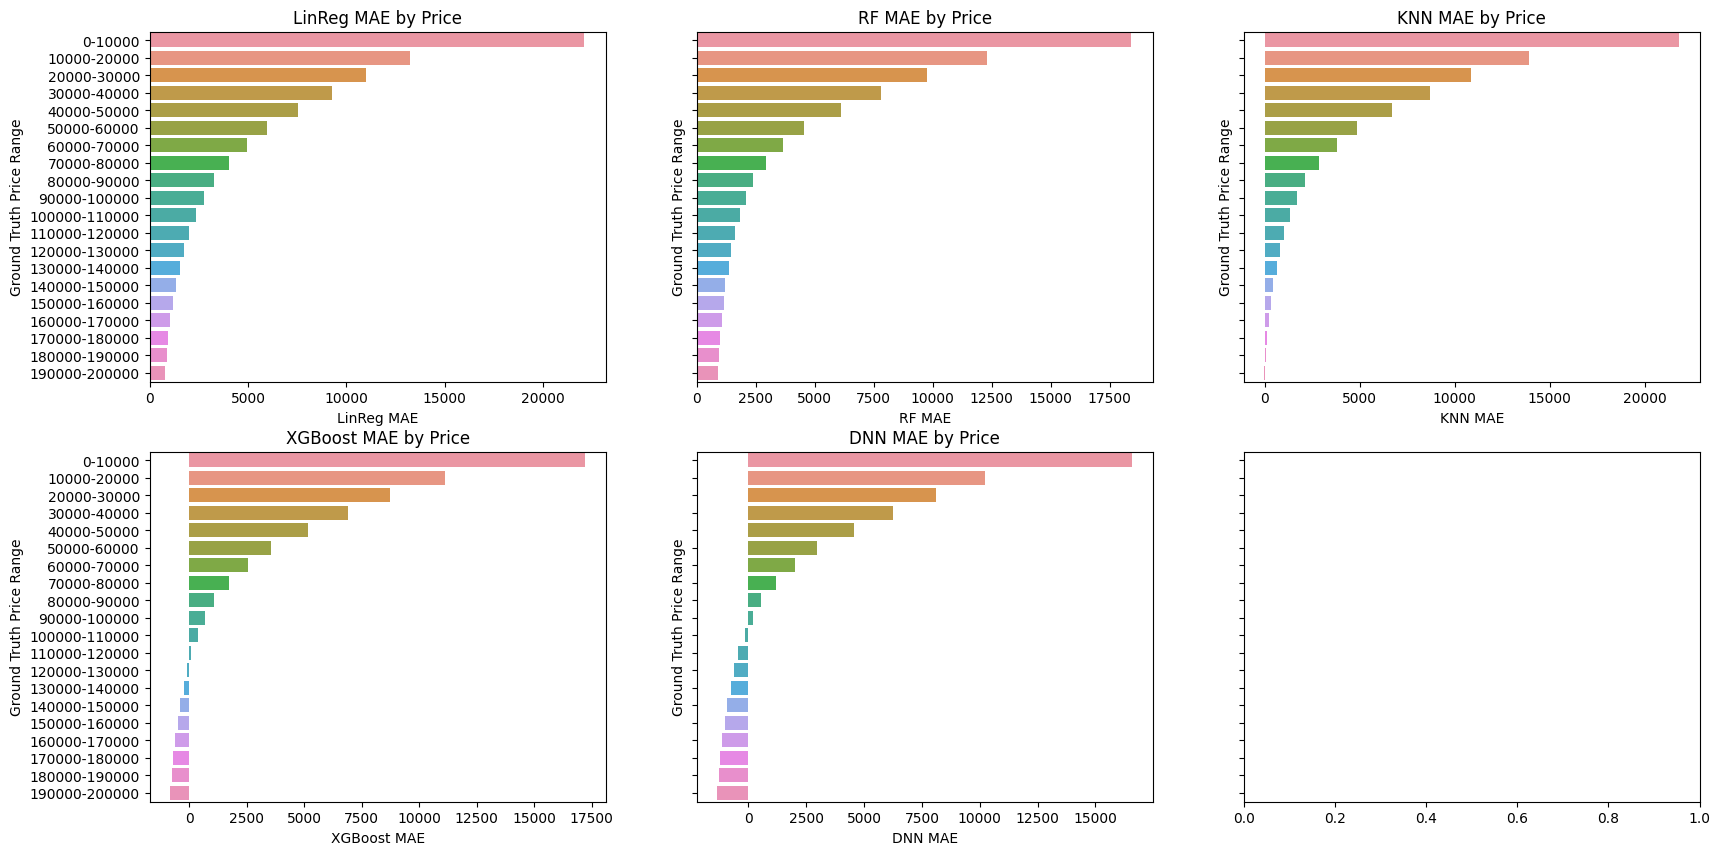

In [28]:
get_scatter(pred_df)